## Features:

### Client:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0


### Invoice data

- Client_id: Unique id for the client
- Invoice_date: Date of the invoice
- Tarif_type: Type of tax
- Counter_number:
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: Consumption_level_1
- Consommation_level_2: Consumption_level_2
- Consommation_level_3: Consumption_level_3
- Consommation_level_4: Consumption_level_4
- Old_index: Old index
- New_index: New index
- Months_number: Month number
- Counter_type: Type of counter


## Some findings

- the "test" = "competition" set (no targets there). Therefore must split the "train" set into train/test sets

- must not aggregate to make a shorter table with customers. Instead predict on TRANSACTIONS. (df.groupby('client_id').nunique())

- the proportion of positives is higher in the merged "transactions" table than the proportion of positives in the "clients" table (0.06 / 0.08).  So you can treat that as "perturbation" of positives in order to increase the number of positives (where they are scarse). I.e. this is one more argument in the favour of predicting on transactions  and then aggregating them to get a prediction for a particular customer.

- the 'months_number' column does not contain actual months. These values do not correspond to the 'creation_date' or 'invoice_date' columns.  Either keep this columns without any transformation or scaling or delete it completeley. Because the test set contains this kidn of wierd values too.

- the features  ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']   are not very promising (in tearms of building univariate logistic regression on them)

- columns 'counter_statue'  is supposed to be integers [0-5] but is of mixed type (object) with some bogus values.  Convert to int, drop the rows with values > 5, because the test set doesnt have any bad values in this column - only the valid integers from 0 to 5

- search for a decent baseline model didn't give decent results. Try non-deterministic baseline model based on the prior (i.e. the proportion of positives in the population)

- eventually agreed to predict transactions (and not fraudulent clients)

- rule-based baseline model on two rules (2005, higher consumption)


In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

In [2]:
# feature preprocessing functions

def preprocess(feature, data):
    functions = {'counter_statue': preprocess_counter_statue}
    feature = feature if type(feature) is str else data.name if type(data) is pd.Series else data.columns[feature]
    function = functions[feature]
    return function(data)

    
# preprocess 'counter_statue'
def preprocess_counter_statue(data):
    col = 'counter_statue'
    data = data[col] if type(data) is pd.DataFrame else data
    sr = data.astype(str)
    mask = sr.isin(list("012345"))
    sr[~mask] = sr[mask].mode().values[0]
    data[:] = sr.astype(int)



In [3]:
path1 = "data/train/client_train.csv"
path2 = "data/train/invoice_train.csv"

path3 = "data/test/client_test.csv"
path4 = "data/test/invoice_test.csv"

In [4]:
# load the data

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)   # low_memory=False

df3 = pd.read_csv(path3)
df4 = pd.read_csv(path4)

/var/folders/21/19jhch7d5dd5fjjxf3d06h9m0000gn/T/ipykernel_85231/3557827750.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(path2)   # low_memory=False


In [5]:
# join tables

# data from the "train" folder (will have to be split into train/test)
df = df1.merge(df2, left_on='client_id', right_on='client_id', how='outer')

# data from the "test" folder (doesn't contain targets)
df_test_zindi = df3.merge(df4, left_on='client_id', right_on='client_id', how='outer')


In [6]:
# not 100% correct - must use the mode of the train set on the test set
preprocess('counter_statue', df)

/var/folders/21/19jhch7d5dd5fjjxf3d06h9m0000gn/T/ipykernel_85231/1424326987.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[:] = sr.astype(int)


In [7]:
# split the data

# make random indeces/mask
m = len(df)
p = .80   # for the train set
nx = np.random.permutation(m)[:int(m*p)]
mask = np.zeros(m).astype(bool)
mask[nx] = True

# split
df_train = df[mask]
df_test = df[~mask]


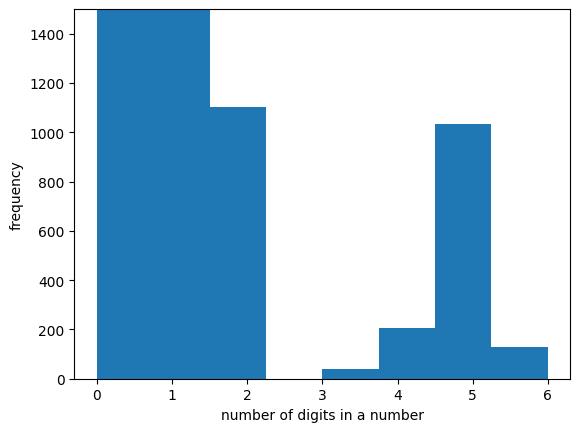

In [8]:
# this histogram gives some idea about the values in 'months_number' 

sr = df['months_number']

plt.hist(np.log10(sr[sr>0]).round(), bins=8);
plt.ylim(0, 1500);
plt.xlabel("number of digits in a number");
plt.ylabel("frequency");

/var/folders/21/19jhch7d5dd5fjjxf3d06h9m0000gn/T/ipykernel_85231/3096769634.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data=dfsample[mask2], x='months_number', y='target', ax=axes[1]);


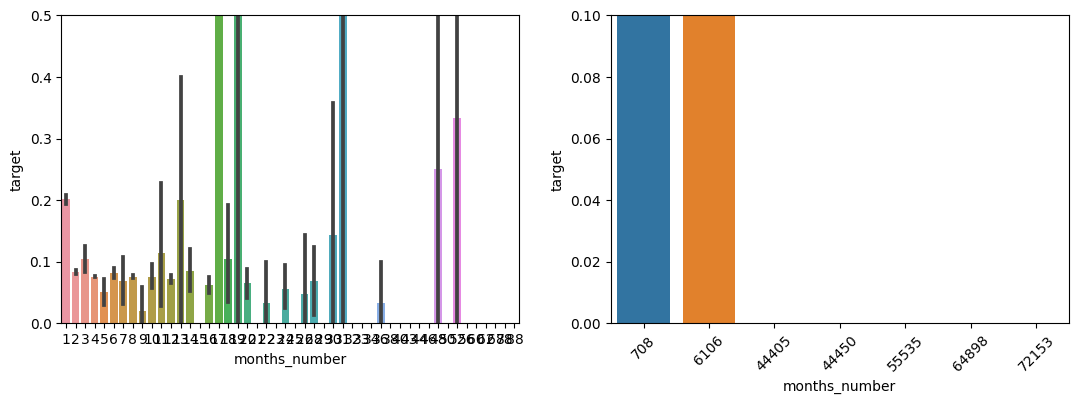

In [9]:
dfsample = df.sample(500_000)

mask1 = dfsample['months_number'] < 100

hay = df.loc[df['months_number'] > 90, 'months_number'].value_counts()[:10].index
mask2 = df['months_number'].isin(hay)

fig, axes = plt.subplots(1,2, figsize=(13,4))

sns.barplot(data=dfsample[mask1], x='months_number', y='target', ax=axes[0]);
axes[0].set_ylim(0, 0.5)

sns.barplot(data=dfsample[mask2], x='months_number', y='target', ax=axes[1]);
axes[1].set_ylim(0, 0.1)
plt.xticks(rotation=45);

need to decide whether we use 'months_number' in our model or not. 

# Choosing a good feature for the Baseline Model

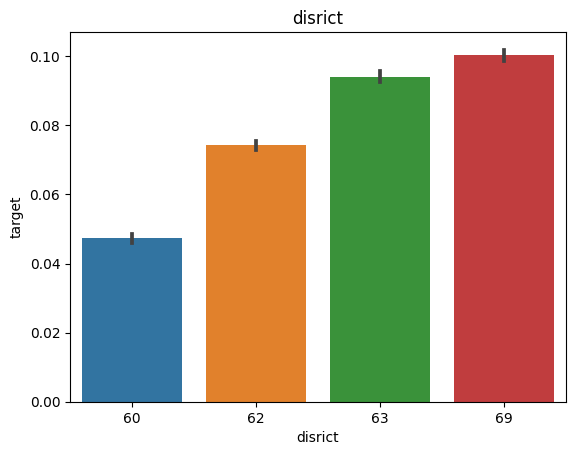

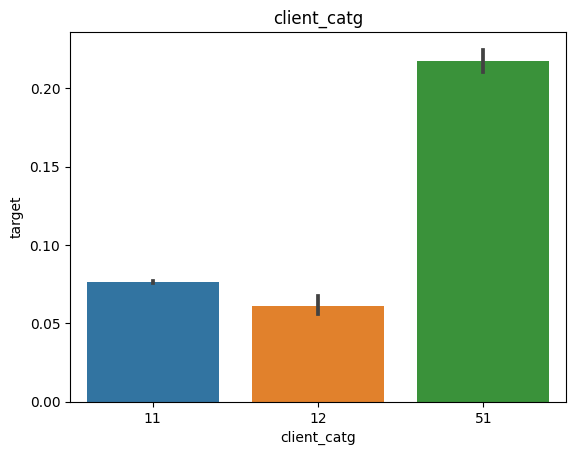

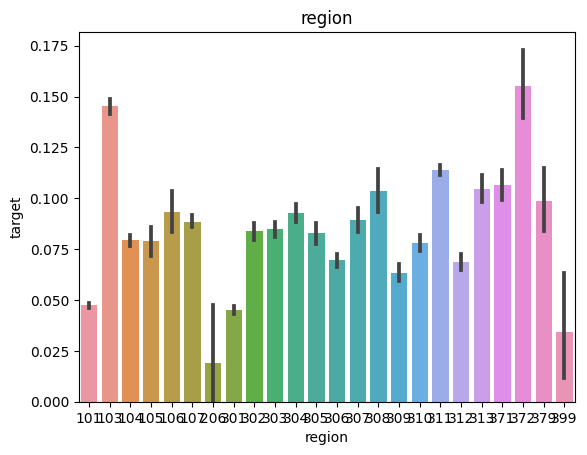

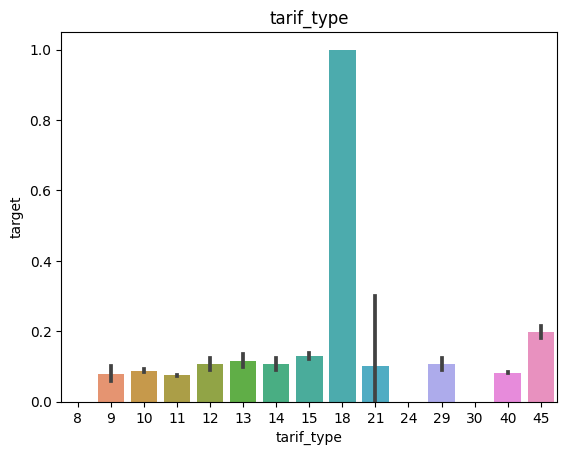

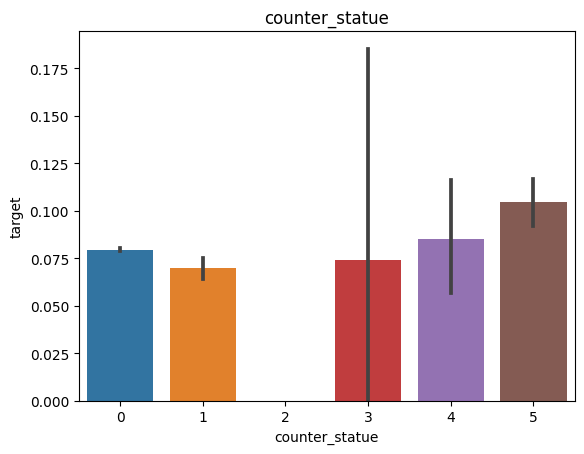

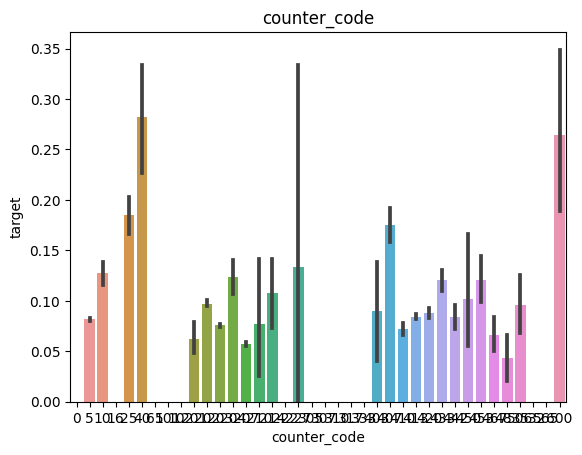

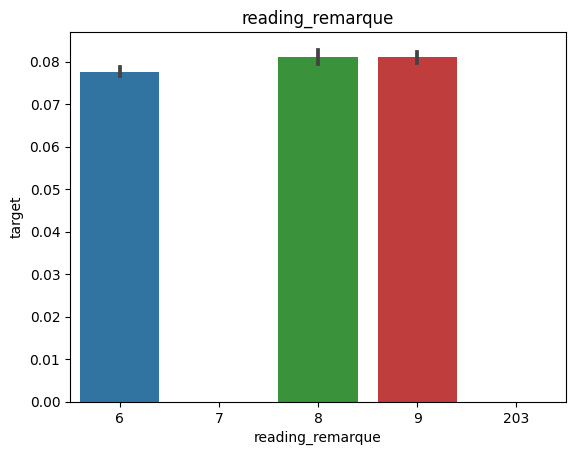

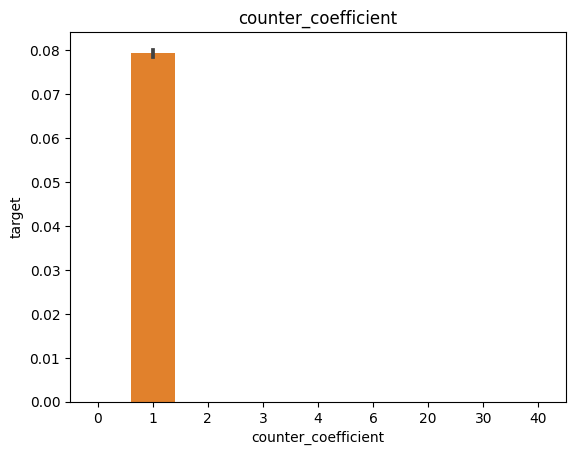

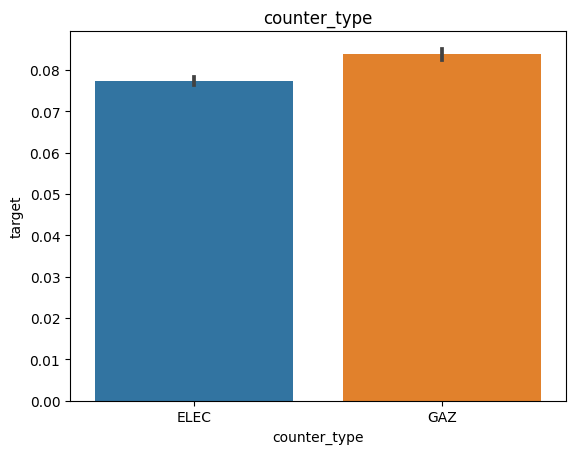

In [10]:
cols = ['disrict',  'client_catg', 'region',  'tarif_type', 
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'counter_type']

for col in cols:
    plt.figure()
    ax = sns.barplot(data=dfsample, x=col, y='target')
    ax.set_title(col)

## Number of unique values in categorical features

In [11]:
cols = ['disrict',  'client_catg', 'region',  'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type']

for col in cols:
    print(col, dfsample[col].nunique())

disrict 4
client_catg 3
region 24
tarif_type 15
counter_number 157775
counter_statue 6
counter_code 38
reading_remarque 5
counter_coefficient 9
consommation_level_1 3970
consommation_level_2 5270
consommation_level_3 1164
consommation_level_4 4511
old_index 72725
new_index 73868
months_number 184
counter_type 2


## Baseline Model

In [12]:
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, confusion_matrix
from sklearn.metrics import classification_report


def baseline(df_train, df_test, return_what='df'):
    """
    Predict a fraud transaction based using these two rules:
        - if a transaction was made before 2005 then predict 0
        - if  the 'consumation_level_X' for that particular transaction 
        is higher than the avarage in that month of the year then predict 1
    """
 
    YEAR = 2005
    PREDICTOR = 'consommation_level_1'
    BETA = 2
    
    # dates
    dates_train = pd.to_datetime(df_train['invoice_date'])
    dates_test = pd.to_datetime(df_test['invoice_date'])
    
    # copy df's and create two columns in each (year, month)
    df_train = df_train.assign(year = dates_train.dt.year, month = dates_train.dt.month)
    df_test = df_test.assign(year = dates_test.dt.year, 
                             month = dates_test.dt.month,
                            prediction=0)
    
    
    df_train = df_train[df_train['year'] > YEAR]

    lookup = df_train[[PREDICTOR, 'month']].groupby(['month']).mean().squeeze()
    
    mask = df_test['year'] > YEAR
    
    func = lambda row : lookup[row['month']] < row[PREDICTOR]
    df_test.loc[mask, 'prediction'] = df_test.loc[mask, ['month', PREDICTOR]].apply(func, axis=1).astype(int)
    
    cols = ['client_id', PREDICTOR, 'invoice_date', 'year', 'month', 'target', 'prediction']
    
    # compute metrics on the test set
    ytrue = df_test['target']
    ypred = df_test['prediction']
    

    fbeta = fbeta_score(ytrue, ypred, beta=BETA)
    print(confusion_matrix(ytrue, ypred))
    print(classification_report(ytrue, ypred))
    print("f2 =", fbeta.round(3))
    
    # what to return
    if return_what:
        if return_what.lower()[0] == 'd':
            return df_test[cols]
        elif return_what.lower()[0] == 's':
            return df_test['prediction']
    return df_test['prediction'].values


In [13]:
predictions = baseline(df_train, df_test, return_what='df')

[[517404 307074]
 [ 45850  25022]]
              precision    recall  f1-score   support

         0.0       0.92      0.63      0.75    824478
         1.0       0.08      0.35      0.12     70872

    accuracy                           0.61    895350
   macro avg       0.50      0.49      0.43    895350
weighted avg       0.85      0.61      0.70    895350

f2 = 0.203


Performance of our baseline model on the test set:

    * f1               0.12
    * f2               0.20
    * recall           0.36
    * precision        0.08
    * accuracy         0.61
    
considerable improvement of f1, f2, recall and precision from our initial simple baseline models. Our current baseline model is based on two rules: <br>
     0 if a transaction was made before 2005<br>
     1 if 'consommation_level_1' is greater than the average for that month